<a href="https://colab.research.google.com/github/QuantumTCode/FIRST-AI-Crash-Course/blob/master/Lesson%20%233%3A%20Recurrent%20Neural%20Networks/Master_of_AI_Crash_Course_3_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIRST AI Crash Course: Recurrent Neural Networks

## Step 0: Import Necessary Libraries

In [0]:
# Pandas is a data processing library
import pandas as pd

#NumPy is mathematical library
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# and TensorFlow is the backbone of Keras, which is the Neural Network Library we will be using
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Splitting Data
from sklearn.model_selection import train_test_split

import pathlib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Let's Begin! All comments are where we will be working to fill in the code in real-time, they're supposed to be blank.

A filled-out copy will be posted to the GitHub once we complete it in the workshop.


In [0]:
!wget https://github.com/QuantumTCode/FIRST-AI-Crash-Course/raw/master/Lesson%20%233:%20Recurrent%20Neural%20Networks/imbd_test_X.csv
!wget https://github.com/QuantumTCode/FIRST-AI-Crash-Course/raw/master/Lesson%20%233:%20Recurrent%20Neural%20Networks/imbd_train.csv.zip && unzip imbd_train.csv.zip && rm imbd_train.csv.zip && rm -rf __MACOSX

--2019-04-19 11:08:03--  https://github.com/QuantumTCode/FIRST-AI-Crash-Course/raw/master/Lesson%20%233:%20Recurrent%20Neural%20Networks/imbd_test_X.csv
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/QuantumTCode/FIRST-AI-Crash-Course/master/Lesson%20%233%3A%20Recurrent%20Neural%20Networks/imbd_test_X.csv [following]
--2019-04-19 11:08:03--  https://raw.githubusercontent.com/QuantumTCode/FIRST-AI-Crash-Course/master/Lesson%20%233%3A%20Recurrent%20Neural%20Networks/imbd_test_X.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13300502 (13M) [text/plain]
Saving to: ‘imbd_test_X.c

In [0]:
train = pd.read_csv("imbd_train.csv")
train.head()

,review,sentiment
0,Imagine The Big Chill with a cast of twenty-so...,0
1,I'd have to say that I've seen worse Sci Fi Ch...,0
2,Director Fabio Barreto got a strange Academy N...,0
3,Pretty bad PRC cheapie which I rarely bother t...,0
4,This is a very intriguing short movie by David...,1


In [0]:
# text preprocessing functions

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

train['review'] = train.review.apply(lambda x: clean_text(x))

In [0]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['review'])

In [0]:
tokenized_train = tokenizer.texts_to_sequences(train['review'])

In [0]:
maxlen = 130
X = pad_sequences(tokenized_train, maxlen=maxlen)
Y = train['sentiment']

In [0]:
train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Embedding(max_features, 128),
    layers.Bidirectional(layers.LSTM(32, return_sequences = True)),
    layers.GlobalMaxPool1D(),
    layers.Dense(20, activation="relu"),
    layers.Dense(1,activation='sigmoid')
  ])

  optimizer = tf.keras.optimizers.Adam()

  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [0]:
model = build_model()

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         768000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1300      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 810,537
Trainable params: 810,537
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Keras callbacks

# Prints a dot for every epoch, just easier to keep track of training
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
    
# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [0]:
EPOCHS = 10
batch_size = 1024

history = model.fit(train_X, train_Y,
          batch_size=batch_size,
          epochs=EPOCHS,
          verbose=0,
          validation_data=(val_X, val_Y),
          callbacks=[PrintDot()])


..........

In [0]:
score = model.evaluate(val_X, val_Y, verbose=0)

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,acc,val_loss,val_acc,epoch
5,0.171358,0.940188,0.325284,0.877250,5
6,0.152980,0.948812,0.347487,0.873375,6
7,0.136488,0.955719,0.372634,0.870750,7
8,0.123121,0.959750,0.398336,0.867750,8
9,0.111449,0.964813,0.407426,0.867750,9


In [0]:
#Plot history of model function

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train acc')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val acc')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

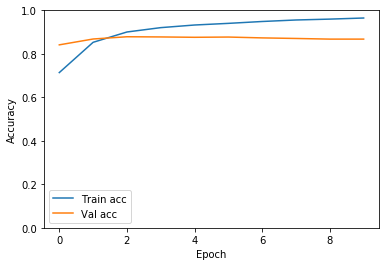

In [0]:
plot_history(history)

In [0]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4074262337088585
Test accuracy: 0.86775


In [0]:
test_X = pd.read_csv("imbd_test_X.csv",header=None)
test_X.rename(columns={0:'review'}, inplace=True)
test_X['review'] = test_X.review.apply(lambda x: clean_text(x))

,review
0,first hate moronic rapper couldnt act gun pres...
1,wealthy horse rancher buenos aire longstanding...
2,cage play drink get high critically praise eli...
3,tell serious boozer drink budweiser many suic...
4,bottom end apocalypse movie scale piece pish c...


In [0]:
tokenized_test = tokenizer.texts_to_sequences(test_X['review'])

In [0]:
test_X = pad_sequences(tokenized_test, maxlen=maxlen)

In [0]:
predictions = np.round(model.predict(test_X)).astype(int)

In [0]:
submission = pd.DataFrame(data=predictions, columns=['sentiment'])

In [0]:
submission.to_csv("submission.csv",index_label="index")